# Compare particle diffusion models
In this notebook we compare the different particle diffusion models. With Fickian diffusion a diffusion equation is solved at all the grid points corresponding to the particle domain with the boundary flux prescribed at the surface related to the local current density. With the other models the average particle concentration is solved for and the surface concentration is prescribed assuming a particular concentration profile within the particle. "uniform" assumes that the concentration inside the particle is uniform and equal to the surface profile - in effect ignoring transport resistance within the particle. "quadratic profile" accounts for the solid diffusion and it's effect on the concentration distribution within the particle. As the current density is a function of surface concentration, the knock-on effects can be seen in the voltage profiles manifesting as different overpotentials.

First we import the packages we're going to use

In [1]:
# install PyBaMM if it is not installed
%pip install pybamm -q
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


In [2]:
particle_options = ["Fickian diffusion", "uniform profile", "quadratic profile", "quartic profile"]

Create a list of models with the different particle diffusion submodels using the options functionality

In [3]:
models = [pybamm.lithium_ion.DFN(options={'particle': opt}, name=opt) for opt in particle_options]

Set up simulations for each model with the current set as an input function as we will change this later to observe the effect on the different models.

In [4]:
simulations = []
for model in models:
    param = model.default_parameter_values
    param["Current function [A]"] = "[input]"
    simulations.append(pybamm.Simulation(model, parameter_values=param))

In [5]:
t_eval = np.linspace(0, 3600, 72)

First run the simulations for each model with a current of 1 [A] - this corresponds to a C-rate of about 1.5 with the standard cell size configured in the default parameters.

In [13]:
solutions_1A = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 1.0})
    solutions_1A.append(sim.solution)
    print("Particle model: {}".format(sim.model.name))
    print("Solve time: {}s".format(sim.solution.solve_time))

Particle model: Fickian diffusion
Solve time: 0.15391049999999495s
Particle model: uniform profile
Solve time: 0.05876410000000476s
Particle model: quadratic profile
Solve time: 0.06699110000000985s
Particle model: quartic profile
Solve time: 0.07730139999999608s


Without solving the diffusion problem in the particles explicitly we can speed up the simulation time x3 assuming uniform profile and up to x2 assuming more complex functions.

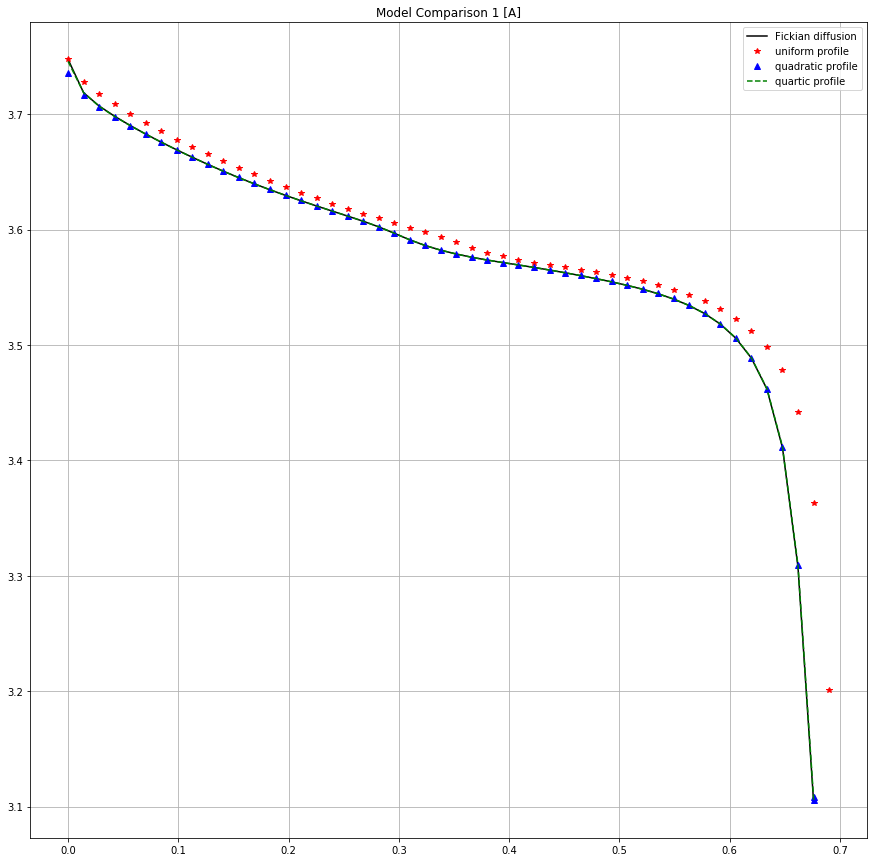

In [7]:
plt.figure(figsize=(15, 15))
style = ['k', 'r*', 'b^', 'g--']
for i in range(len(models)):
    plt.plot(solutions_1A[i]['Time [h]'].entries,
             solutions_1A[i]['Terminal voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 1 [A]')
plt.grid()

We can see that the Fickian and quadratic and quartic profiles agree very well and that the uniform profile over-predicts the cell voltage and capacity by ignoring this transport resistance. The only significant difference between the Fickian and quadratic models is on the first datapoint when transient effects after the initial state may differ. Observe what happens next when we increase the current.

In [8]:
solutions_2A = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 2.0})
    solutions_2A.append(sim.solution)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../c

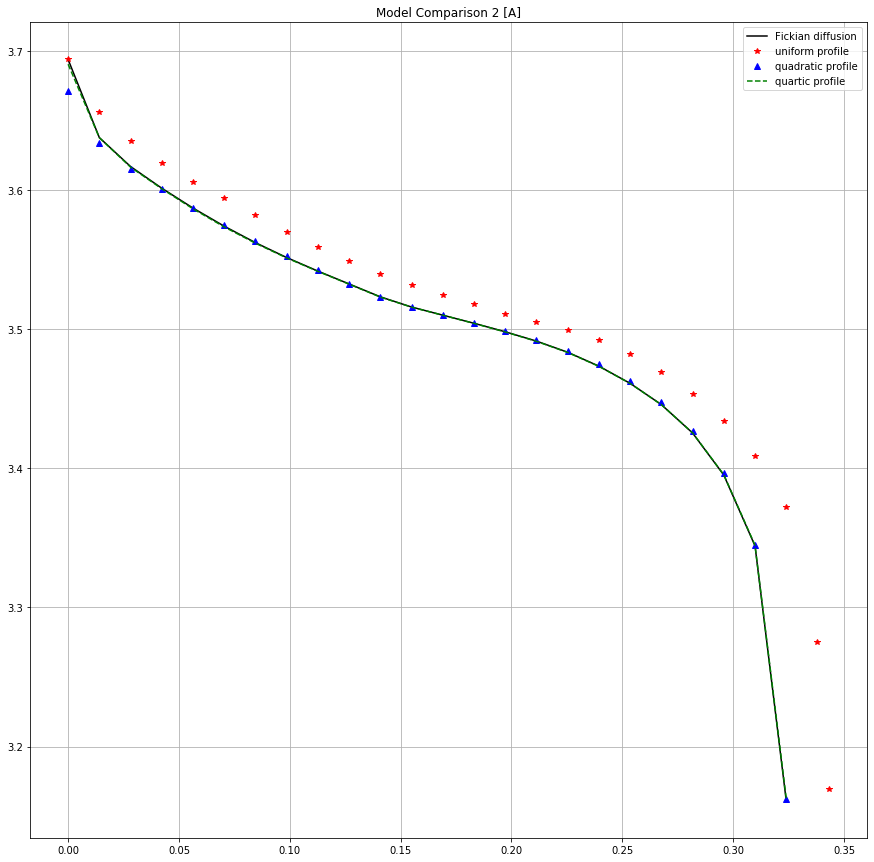

In [9]:
plt.figure(figsize=(15, 15))
for i in range(len(models)):
    plt.plot(solutions_2A[i]['Time [h]'].entries,
             solutions_2A[i]['Terminal voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 2 [A]')
plt.grid()

The quadratic model is still much better at approximating Fickian diffusion and the relative error in the uniform model has increased. However, the initial error in the quadratic model has grown slightly. Increasing current even more will highlight the problem further. The quartic model is still providing an excellent match to the Fickian diffusion profile.

In [10]:
t_eval = np.linspace(0, 720, 73)
solutions_5A = []
for sim in simulations:
    sim.solve(t_eval, inputs={"Current function [A]": 5.0})
    solutions_5A.append(sim.solution)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:827: Calculating Jacobian failed
psetup failed: .../c

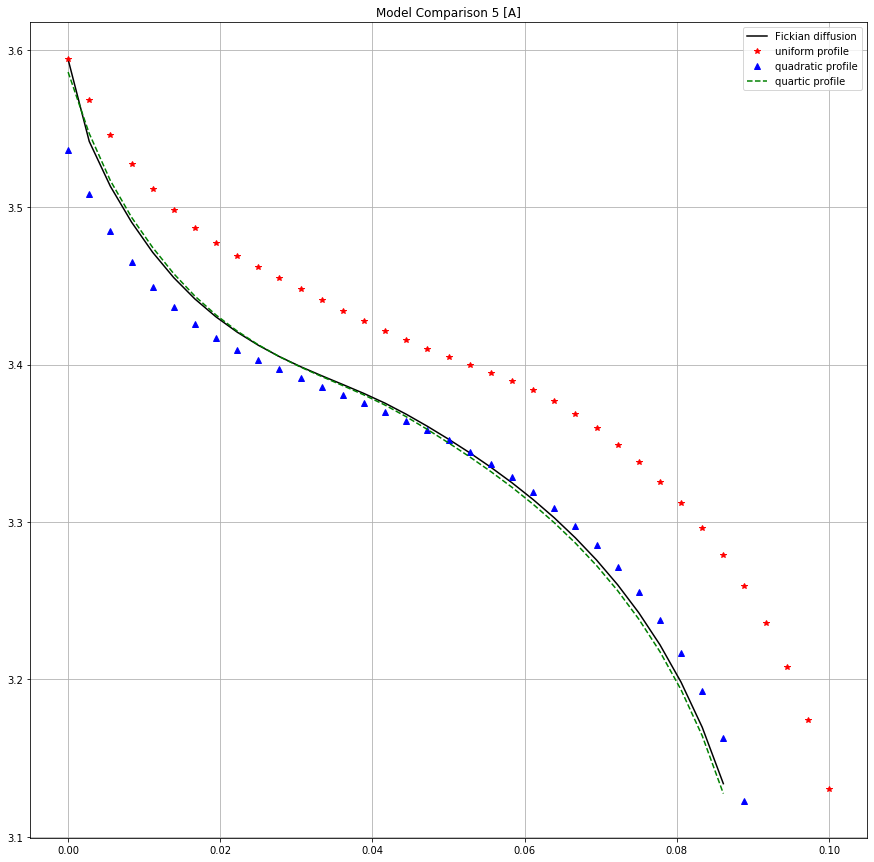

In [11]:
plt.figure(figsize=(15, 15))
for i in range(len(models)):
    plt.plot(solutions_5A[i]['Time [h]'].entries,
             solutions_5A[i]['Terminal voltage [V]'].entries, style[i], label=particle_options[i])
plt.legend()
plt.title('Model Comparison 5 [A]')
plt.grid()

Now the quadratic profile assumption begins to breakdown and that initial error propagates much further into the discharge. Happily the quartic model is higher-order and the match to the Fickian profile is still very good.

In [12]:
quick_plot = pybamm.QuickPlot(solutions_5A)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=360.0, step=3.6), Output()), _dom_classes=('…